In [79]:
import math
import os
import time

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

import numpy as np
import ot as pot
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.tensorboard import SummaryWriter

# import torchdyn
# from torchdyn.core import NeuralODE
# from torchdyn.datasets import generate_moons

# from torchcfm.conditional_flow_matching import *
# from models_v2 import *
# from torchcfm.utils import *
from torchcfm.optimal_transport import OTPlanSampler

import scipy as sp

from tqdm import tqdm
import imageio


from multiprocessing import Pool

from concurrent.futures import ThreadPoolExecutor
# from utils_hf import *
# savedir = "models/obs_gauss_gauss"
# os.makedirs(savedir, exist_ok=True)



In [80]:
ot_sampler = OTPlanSampler(method="exact")

In [386]:
alpha = 5/2
beta = 1/2
def r(x, plot = False):
    if plot:
        return np.linalg.norm(x, axis=-1)**2
    else:
        return (np.linalg.norm(x, axis=-1)**2)

def obstacle(x,plot = False):
    exp_inv = np.exp(-alpha*(r(x)-.5))#[:,None]
    return -beta*exp_inv/(1+exp_inv)   

def obstacle_grad(x):
    # print(x)
    exp_inv = np.exp(-alpha*(r(x)-.5))[:,None]
    return 2*beta*alpha*(exp_inv)*(1/(1+exp_inv)**2)*x

def grad_pot(x):
    exp_inv = np.exp(-alpha*(r(x)-.5))
    return 2*beta*alpha*(exp_inv)*(1/(1+exp_inv)**2)*x

    

In [387]:
x = np.linspace(-1.5,1.5,100)
y = np.linspace(-1.5,1.5,100)
X,Y = np.meshgrid(x,y)
Z = obstacle(np.stack([X,Y],axis=-1),True).reshape(100,100)



In [498]:
# Dynamics for mean and std

def f(t,x):
    # x = [mu, mu',sigma,sigma']
    mu = x[:2]
    mu_p = x[2:4]
    sigma = x[4]
    sigma_p = x[5]
    mesh_elements = x.shape[1]
    result = np.zeros_like(x)
    
    
    for i in range(mesh_elements):
        mu_i = mu[:,i]
        mu_p_i = mu_p[:,i]
        sigma_i = sigma[i]
        sigma_p_i = np.array([sigma_p[i]])   
        samples_gauss = np.random.randn(100_000,2)     
        samples = sigma_i*samples_gauss+mu_i
        eval_grad = obstacle_grad(samples)
        mu_pp = np.mean(eval_grad,axis=0)
        # eval_grad = np.expand_dims(eval_grad)
        dot_produtc = np.einsum('bi,bi->b',eval_grad,samples_gauss)
        # print(dot_produtc.shape)
        # Why does including acceleration make it worse?
        sigma_pp = 1*np.array([np.mean(dot_produtc,axis=0)])
        # print(np.mean(dot_produtc,axis=0))
        # print(sigma_p,sigma_pp)
        res = np.concatenate([mu_p_i,-mu_pp,sigma_p_i,-sigma_pp])
        result[:,i] = res
    # print(res)
    return result

def f_mu(t,x):
    # x = [mu, mu']
    x1 = x[:2]
    x2 = x[2:4]
    
    mesh_elements = x.shape[1]
    result = np.zeros_like(x)
    for i in range(mesh_elements):
        x1_i = x1[:,i]
        x2_i = x2[:,i]
        x2_p  = -grad_pot(x1_i)
        x1_p = x2_i
        # print(x1_p,x2_p)
        res = np.concatenate([x1_p,x2_p])
        result[:,i] = res
    return result

def f_std(t,x,mu):
    #x:  [sigma,sigma']
    #mu: function of t that returns mu
    sigma = x[:1]
    sigma_p = x[1:2]

    mesh_elements = x.shape[1]
    result = np.zeros_like(x)
    for i in range(mesh_elements):
        samples_gauss = np.random.randn(10_000,2)
        sigma_i = sigma[i]
        sigma_p_i = np.array([sigma_p[i]])        
        samples = sigma_i*samples_gauss+mu(t)
        eval_grad = obstacle_grad(samples)
        dot_produtc = np.einsum('bi,bi->b',eval_grad,samples_gauss)
        sigma_pp = 1*np.array([np.mean(dot_produtc,axis=0)])
        res = np.concatenate([sigma_p_i,-sigma_pp])
        result[:,i] = res
    return result

def f_std_2(t,x,mu):
    #x:  [sigma,sigma']
    #mu: function of t that returns mu
    sigma = x[:1]
    sigma_p = x[1:2]
    samples_gauss = np.random.randn(100_000,2)
    sigma_i = sigma
    sigma_p_i = sigma_p       
    samples = sigma_i*samples_gauss+mu(t)
    eval_grad = obstacle_grad(samples)
    dot_produtc = np.einsum('bi,bi->b',eval_grad,samples_gauss)
    sigma_pp = 1*np.array([np.mean(dot_produtc,axis=0)])
    # print(sigma_p_i,-sigma_pp)
    res = np.concatenate([sigma_p_i,-sigma_pp])
    return res

        


def solve_bvp(args):
    i,x0, x1, t = args
    # Define mean of Gaussian distributions
    mu_0 = x0
    mu_1 = x1
    sigma_0 = np.array([0.1])
    sigma_1 = np.array([0.1])
    x = np.linspace(0,1,10)
    y = np.full((6,x.shape[0]),0.00)
    

    # Solve BVP for Gaussians
    bc = lambda ya,yb: np.concatenate([ya[:2]-mu_0,yb[:2]-mu_1,ya[4]-sigma_0,yb[4]-sigma_1])
    sol = sp.integrate.solve_bvp(f,bc,x,y,tol = 1e-1,max_nodes=20)
    eval =sol.sol(t)

    mu_t = np.squeeze(eval[:2])
    mu_p_t = np.squeeze(eval[2:4])
    sigma_t = np.squeeze(eval[4])
    sigma_p_t = np.squeeze(eval[5])


    return mu_t, mu_p_t, sigma_t, sigma_p_t



In [499]:
N =  10
mu_0 = np.array([-.5,-.85])
mu_1 = np.array([-.5,-.75])
# mu_0_p = np.array([-1,1.0])
sigma_0 = np.array([.1])
sigma_1 = np.array([.1])
x = np.linspace(0,1,N)

y_sig = np.full((2,x.shape[0]),0.00)
y_mu = np.full((4,x.shape[0]),0.00)



def bc_mu(ya,yb):   
    return np.concatenate([ya[:2]-mu_0,yb[:2]-mu_1])

sol_mu = sp.integrate.solve_bvp(f_mu,bc_mu,x,y_mu,tol = 1e-1,verbose=2)




   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.99e-03       0.00e+00          10              0       
Solved in 1 iterations, number of nodes 10. 
Maximum relative residual: 1.99e-03 
Maximum boundary residual: 0.00e+00


In [500]:
def bc_sig(ya,yb):
    
    return np.concatenate([ya[0]-sigma_0,yb[1]-sigma_1])

y0_std = np.array([0.1,.35])

sol_sig = sp.integrate.solve_ivp(f_std_2,[0,1],y0_std,method='RK23',dense_output=True,args=(lambda t: sol_mu.sol(t)[:2],))


In [501]:
mu_t = lambda t: sol_mu.sol(t)[:2]
mu_p_t = lambda t: sol_mu.sol(t)[2:4]
sigma_t = lambda t: sol_sig.sol(t)[0]
sigma_p_t = lambda t: sol_sig.sol(t)[1]

t = np.linspace(0,1,100)
mu_d = mu_t(t)
mu_p_d = mu_p_t(t)
sigma_d = sigma_t(t)
sigma_p_d = sigma_p_t(t)



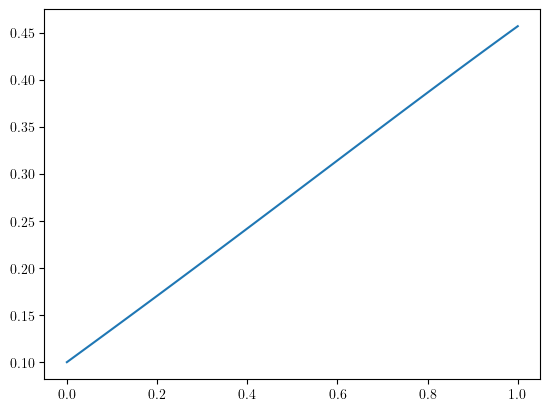

In [502]:
plt.plot(t,sigma_d)

In [503]:
hamiltonian_fake_dist = eval_hamiltonian(mu_d,mu_p_d,sigma_d,sigma_p_d)

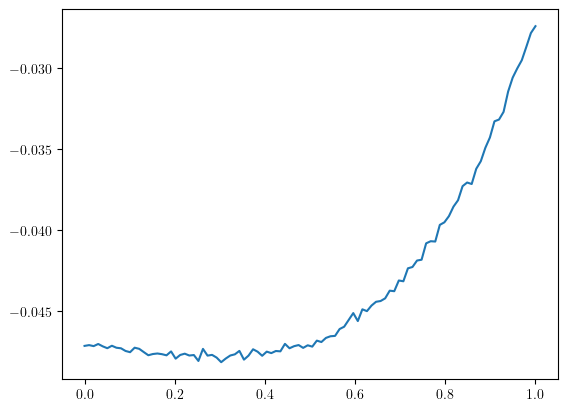

In [504]:
plt.plot(t,hamiltonian_fake_dist)

In [505]:
error_hamiltonian_fake = np.abs(hamiltonian_fake_dist-hamiltonian_fake_dist[0])/np.abs(hamiltonian_fake_dist[0])*100

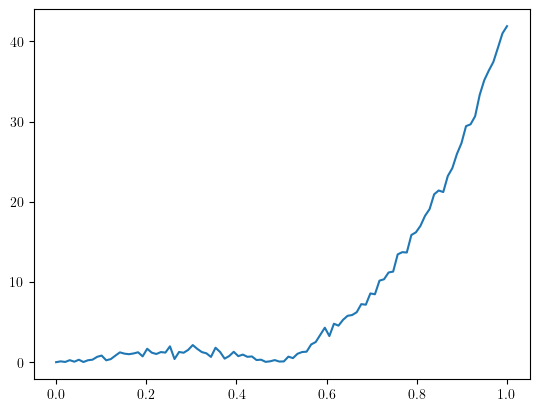

In [506]:
plt.plot(t,error_hamiltonian_fake)

In [507]:
# for k in range(10):
#     print(k)
#     bs = 50
#     mu_0 = torch.tensor([-2.0,0.0])
#     mu_1 = torch.tensor([2.0,0.0])
#     sigma_0 = torch.tensor([1])
#     sigma_1 = torch.tensor([1])

#     mu = MultivariateNormal(mu_0, torch.eye(2)*sigma_0)
#     nu = MultivariateNormal(mu_1, torch.eye(2)*sigma_1)
#     x0 = mu.sample((bs,))
#     x1 = nu.sample((bs,))

#     t = torch.rand(bs,1)


#     x0, x1 = ot_sampler.sample_plan(x0, x1)

#     with ThreadPoolExecutor() as executor:
#         results = list(executor.map(solve_bvp, [(i,x0[i].cpu().numpy(), x1[i].cpu().numpy(), t[i].cpu().numpy()) for i in range(bs)]))
#     # print(results)

#     mu_t, mu_p_t, sigma_t, sigma_p_t = zip(*results)


In [508]:
# mu_t = np.stack(mu_t,axis=0)

In [509]:
N =  10
# mu_0 = np.array([1.25,1.25])
# mu_1 = np.array([1,1.5])
# mu_0_p = np.array([-1,1.0])
sigma_0 = np.array([.1])
sigma_1 = np.array([.1])
x = np.linspace(0,1,N)
mu_t = np.stack([mu_0[0]+(mu_1[0]-mu_0[0])*x,mu_0[1]+(mu_1[1]-mu_0[1])*x],axis=1)

bc = lambda ya,yb: np.concatenate([ya[:2]-mu_0,yb[:2]-mu_1,ya[4]-sigma_0,yb[4]-sigma_1])


def bc_sig(ya,yb):
    
    return np.concatenate([ya[0]-sigma_0,yb[1]-sigma_1])

def bc_mu(ya,yb):   
    return np.concatenate([ya[:2]-mu_0,yb[:2]-mu_1])

y = np.full((6,x.shape[0]),0.00)
y_sig = np.full((2,x.shape[0]),0.00)
y_mu = np.full((4,x.shape[0]),0.00)
# y[5] = -0.01


sol = sp.integrate.solve_bvp(f,bc,x,y,tol = 1e-1,verbose=2)


   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  


       1          1.99e-03       0.00e+00          10              0       
Solved in 1 iterations, number of nodes 10. 
Maximum relative residual: 1.99e-03 
Maximum boundary residual: 0.00e+00


In [510]:
t =np.linspace(0,1,100)
eval =sol.sol(t)
mu = eval[:2]
mu_p = eval[2:4]
sigma = eval[4]
sigma_p = eval[5]


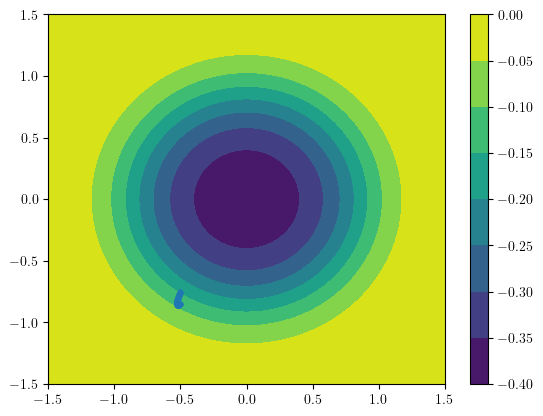

In [511]:
plt.contourf(X,Y,Z)
plt.colorbar()
plt.plot(mu[0,:],mu[1,:],'.')

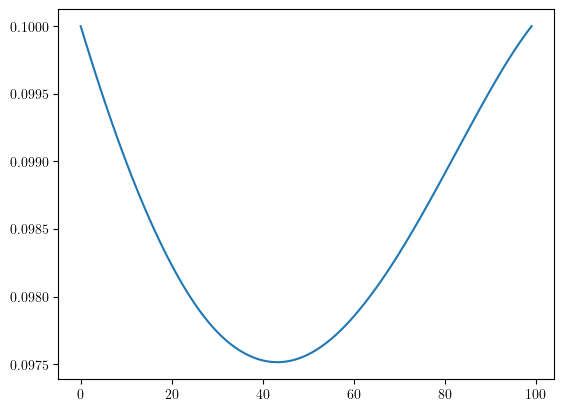

In [528]:
plt.plot(sigma)

In [513]:
def eval_hamiltonian(mu,mu_p,sig,sig_p):
    '''
    mu: [2,N]
    mu_p: [2,N]
    sig: [1,N]
    sig_p: [1,N]
    '''
    N = mu.shape[1]
    
    res = np.zeros(N)
    kinetic_mu = np.linalg.norm(mu_p, axis=0)**2/2
    kinetic_sig = sig_p**2/2
    kinetic = kinetic_mu + kinetic_sig
    
    for i in range(N):
        mu_i = mu[:,i]
        sigma_i = sig[i]
        samples_gauss = np.random.randn(200_000,2)    
        samples = sigma_i*samples_gauss+mu_i 
        eval_obstacle = obstacle(samples,True)
        res[i] = np.mean(eval_obstacle)
    return kinetic + res
    

In [514]:
hamiltonian_dist = eval_hamiltonian(mu,mu_p,sigma,sigma_p)


In [515]:
percentual_hamiltonian = np.abs(hamiltonian_dist-hamiltonian_dist[0])/np.abs(hamiltonian_dist[0])*100

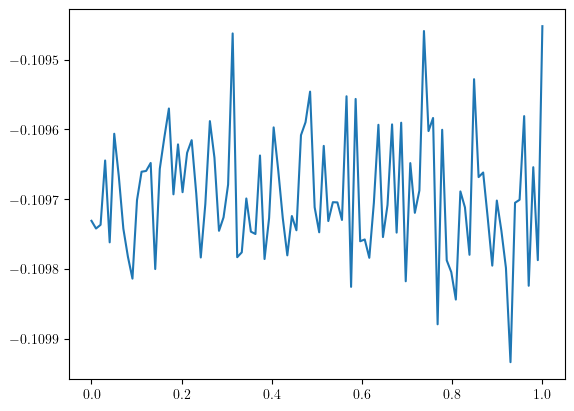

In [516]:
plt.plot(t,hamiltonian_dist)

Text(0.5, 1.0, 'Percentual change in Hamiltonian along PWHF path ')

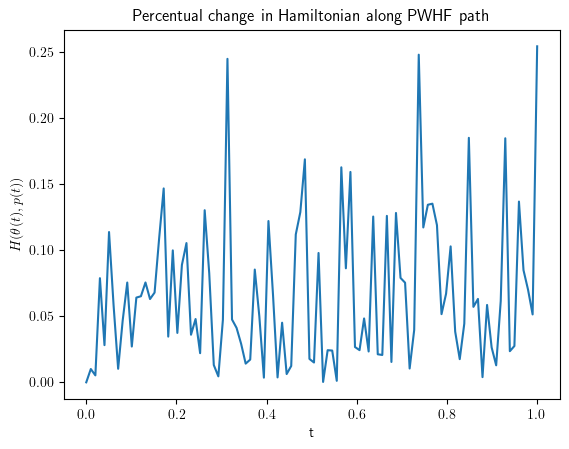

In [517]:

plt.plot(t,percentual_hamiltonian)
plt.xlabel('t')
plt.ylabel(r'$H(\theta(t),p(t))$')
plt.title('Percentual change in Hamiltonian along PWHF path ')
# plt.savefig(savedir+'/hamiltonian_pwhf.png',dpi=300)

In [518]:
def eval_hamiltonian(mu,mu_p,sig,sig_p):
    '''
    See (3.18) PWHF
    '''
    '''
    mu: [2,N]
    mu_p: [2,N]
    sig: [1,N]
    sig_p: [1,N]
    '''
    N = mu.shape[1]
    
    res = np.zeros(N)
    kinetic_mu = np.linalg.norm(mu_p, axis=0)**2/2
    kinetic_sig = sig_p**2/2
    kinetic = kinetic_mu + kinetic_sig
    
    for i in range(N):
        mu_i = mu[:,i]
        sigma_i = sig[i]
        samples_gauss = np.random.randn(200_000,2)    
        samples = sigma_i*samples_gauss+mu_i 
        eval_obstacle = obstacle(samples,True)
        res[i] = np.mean(eval_obstacle)
    return kinetic + res
    

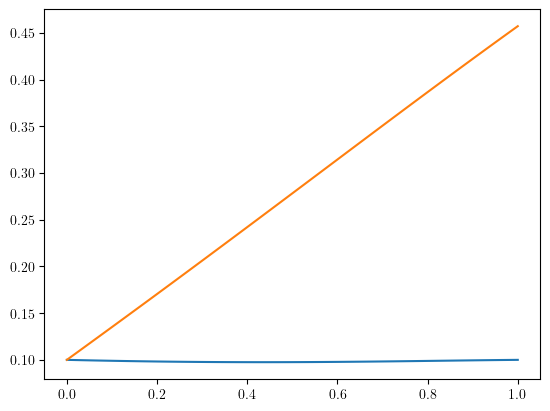

In [519]:
plt.plot(t,sigma)
plt.plot(t,sigma_d)

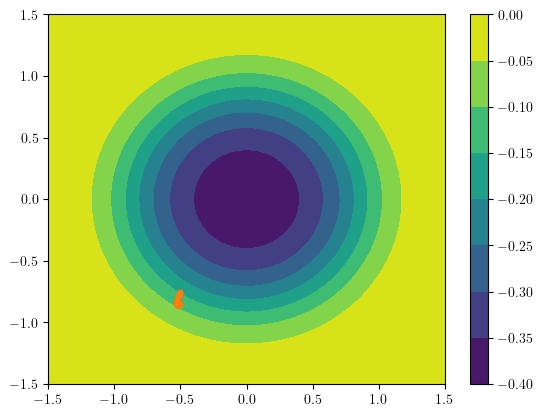

In [520]:
# mu_t = mu_f(np.linspace(0,1,100))
plt.contourf(X,Y,Z)
plt.colorbar()
plt.plot(mu[0,:],mu[1,:],'.')
plt.plot(mu_d[0,:],mu_d[1,:],'.')

Deterministic dynamics

In [521]:
# alpha = 10/2
# beta = 10
def pot(x,plot = False):
    return -beta/(1+np.exp(alpha*(r(x)-.5)))
def grad_pot(x):
    exp_inv = np.exp(-alpha*(r(x)-.5))
    return 2*beta*alpha*(exp_inv)*(1/(1+exp_inv)**2)*x
def hamiltonian(x,x_p):
    return pot(x)+np.linalg.norm(x_p)**2/2

In [522]:
x = np.linspace(-1.5,1.5,100)
y = np.linspace(-1.5,1.5,100)
X,Y = np.meshgrid(x,y)
Z = pot(np.stack([X,Y],axis=-1),True).reshape((100,100))
print(Z.shape)

(100, 100)


In [523]:
def f_trial(t,x):
    x1 = x[:2]
    x2 = x[2:4]
    
    mesh_elements = x.shape[1]
    result = np.zeros_like(x)
    for i in range(mesh_elements):
        x1_i = x1[:,i]
        x2_i = x2[:,i]
        x2_p  = -grad_pot(x1_i)
        x1_p = x2_i
        # print(x1_p,x2_p)
        res = np.concatenate([x1_p,x2_p])
        result[:,i] = res
    return result
        

In [524]:
x0 = np.array([1,0])
x1 = np.array([0,-1])
x = np.linspace(0,1,3)
x_t = np.stack([x0[0]+(x1[0]-x0[0])*x,x0[1]+(x1[1]-x0[1])*x],axis=1)

y = np.full((4,x.shape[0]),0.001)
# y[0] = x_t[:,0]
# y[1] = x_t[:,1]


def bc(ya,yb):
    return np.concatenate([ya[:2]-mu_0,yb[:2]-mu_1])

sol = sp.integrate.solve_bvp(f_trial,bc,x,y,verbose=2)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          7.47e-04       0.00e+00           3              0       
Solved in 1 iterations, number of nodes 3. 
Maximum relative residual: 7.47e-04 
Maximum boundary residual: 0.00e+00


In [525]:
t =np.linspace(0,1,100)
eval =sol.sol(t)
x = eval[:2]
x_p = eval[2:4]

Text(0.5, 1.0, 'Comparison of paths on potential field')

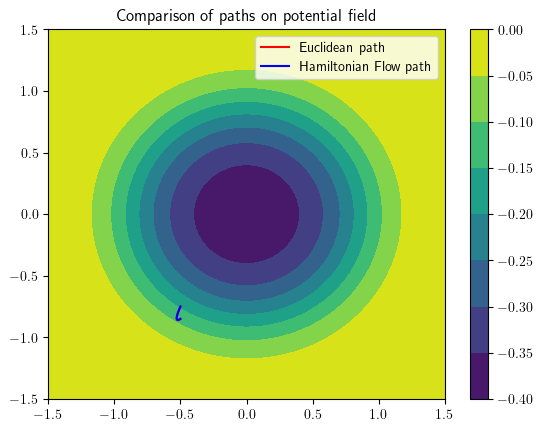

In [526]:
plt.contourf(X,Y,Z)
plt.colorbar()
plt.plot(x[0,:],x[1,:],'r',label = 'Euclidean path')
plt.plot(mu[0,:],mu[1,:],'b',label = 'Hamiltonian Flow path')
plt.legend()
plt.title('Comparison of paths on potential field')

# plt.savefig(savedir+'/path_comparison.png',dpi=300)


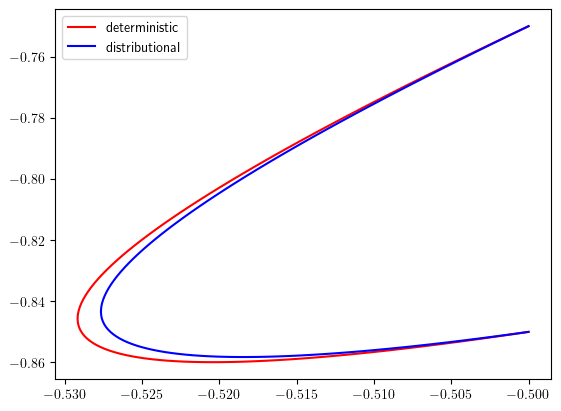

In [527]:
plt.plot(x[0,:],x[1,:],'r',label='deterministic')
plt.plot(mu[0,:],mu[1,:],'b',label='distributional')
plt.legend()

In [436]:
sig_det = np.ones_like(x[0,:])*sigma_0
sig_det_p = np.zeros_like(x[0,:])
hamiltonian_det = eval_hamiltonian(x,x_p,sig_det,sig_det_p)

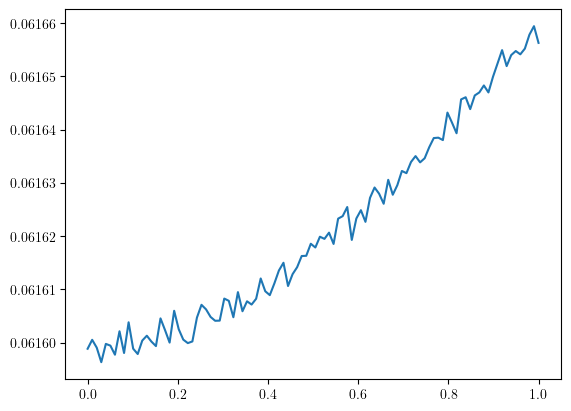

In [437]:
plt.plot(t,hamiltonian_det)

In [438]:
percentual_hamiltonian_det = np.abs(hamiltonian_det-hamiltonian_det[0])/np.abs(hamiltonian_det[0])*100

Text(0.5, 1.0, 'Percentual change in Hamiltonian along Euclidean path')

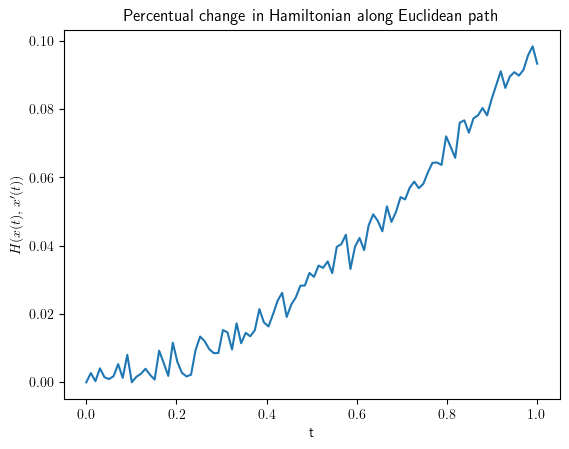

In [439]:


plt.plot(t,percentual_hamiltonian_det)
plt.xlabel('t')
plt.ylabel("$H(x(t),x'(t))$")
plt.title('Percentual change in Hamiltonian along Euclidean path')
# plt.savefig(savedir+'/hamiltonian_det.png',dpi=300)
